The idea: for a prediction "What is the QRANK for SRANK STAXON" -> QTAXON
1. Get GBIF backbone
1. Look up ID for STAXON
1. Look up Accepted ID for QTAXON
1. See if QTAXON's Accepted ID is the QRANK_key (or any key) for STAXON

In [1]:
import pandas as pd
import numpy as np
import os
import sys

In [9]:
rank_predictions = pd.read_csv(open("results/rank-predictions.tsv"), sep="\t", dtype=str, index_col=0)\
    .map(str.lower)

In [3]:
year = 2022
taxonomy = pd.read_csv(open(f"../../preston/gbif-backbone-{year}.tsv"), sep="\t", dtype=str).applymap(lambda x: str(x).lower())
taxonomy.set_index("id", drop=False, inplace=True)
taxonomy.rename(columns={x: x[:-4] for x in taxonomy.columns if "_key" in x}, inplace=True)
taxonomy.head(1)

,id,status,rank,kingdom,phylum,class,order,family,genus,species,name_id,scientific_name,canonical_name
id,,,,,,,,,,,,,
5184,5184,accepted,family,1,43,205,838,5184,\n,\n,8028810,pachycordylidae,pachycordylidae


In [4]:
rank_predictions = pd.read_csv(open("results/rank-predictions.tsv"), sep="\t", dtype=str, index_col=0).applymap(lambda x: str(x).lower())
rank_predictions.head(1)

,query rank,subject rank,taxon,responses
question number,,,,
results/indexTerms-phylum.tsv:0,kingdom,phylum,annelida,"animalia,animalia,animalia,animalia,animalia,a..."


In [4]:
name_to_id_cache = {}

def name_to_id(name, rank):
    id = name_to_id_cache.get(f"{rank},{name}")
    if id == None:
        # Assume all homonyms point to the same accepted key, so just take the first one
        id = taxonomy[(taxonomy["canonical_name"] == name) * (taxonomy["rank"] == rank)][rank].get(0)
        name_to_id_cache[f"{rank},{name}"] = id
    return id

In [5]:
from functools import reduce

def count(iterable):
    return reduce(lambda a,b: a + 1, iterable, 0)

def score_one(r_taxon_id, s_taxon_id, query_rank) -> bool:
    return taxonomy.loc[s_taxon_id][query_rank] == r_taxon_id

def score(rank_prediction) -> pd.Series:
    s_taxon_id = name_to_id(rank_prediction["taxon"], rank_prediction["subject rank"])
    query_rank = rank_prediction["query rank"]
    ids = list(filter(lambda x: x != None, [name_to_id(response, query_rank) for response in rank_prediction["responses"].split(",")]))
    
    return pd.Series({
        "num_correct": np.nan if s_taxon_id == None else count(filter(lambda x: x == taxonomy.loc[s_taxon_id][query_rank] == x, ids)),
        "num_response": len(ids)
    })

In [6]:
def dereference(id: str) -> str:
    return str(taxonomy["canonical_name"].get(id, ""))

def dereference_all(id_df: pd.Series):
    return id_df.apply(dereference)

# dereference_all(taxonomy.loc["1"][["kingdom", "phylum", "class", "order", "family", "genus", "species"]])
# dereference_all(taxonomy.loc["5184"])

In [7]:
scores_path = "processed/scores.tsv"
if os.path.exists(scores_path):
    scores = pd.read_csv(open(scores_path), sep="\t", index_col=0)
else:
    i = 0
    n = len(rank_predictions)
    def score_with_progress(x, n):
        global i
        i += 1
        print(f"{i}/{n}\t{i/n:.0%}", end="\r", flush=True)
        return score(x)

    scores = rank_predictions.apply(lambda x: score_with_progress(x, n), axis=1)
    scores.to_csv(open(scores_path, "w"), sep="\t")

In [8]:
taxonomy[taxonomy["canonical_name"] == "echinodermata"]

,id,status,rank,kingdom,phylum,class,order,family,genus,species,name_id,scientific_name,canonical_name
id,,,,,,,,,,,,,
50,50,accepted,phylum,1,50,\n,\n,\n,\n,\n,3808507,echinodermata,echinodermata


In [9]:
name_to_id("ophiurida", "order")

In [20]:
scoreacs[scoreacs["subject rank"] == "family"].head()

,num_correct,num_response,query rank,subject rank,taxon,responses,accs
question number,,,,,,,
results/indexTerms-family.tsv:0,10.0,10.0,kingdom,family,nereididae,"animalia,animalia,animalia,animalia,animalia,a...",1.0
results/indexTerms-family.tsv:1,10.0,10.0,phylum,family,nereididae,"annelida,annelida,annelida,annelida,annelida,a...",1.0
results/indexTerms-family.tsv:2,10.0,10.0,class,family,nereididae,"polychaeta,polychaeta,polychaeta,polychaeta,po...",1.0
results/indexTerms-family.tsv:3,10.0,10.0,order,family,nereididae,"phyllodocida,phyllodocida,phyllodocida,phyllod...",1.0
results/indexTerms-family.tsv:4,10.0,10.0,kingdom,family,spionidae,"animalia,animalia,animalia,animalia,animalia,a...",1.0


In [41]:
scoreacs[scoreacs["subject rank"] == "genus"]["taxon"].value_counts()

taxon
nereis            5
filago            5
hymenothrix       5
rudbeckia         5
hymenoxys         5
                 ..
acanthotrophon    5
rostellites       5
acanthais         5
trophonopsis      5
trichloris        5
Name: count, Length: 2199, dtype: int64

In [47]:
kpfg_scores = scoreacs[scoreacs["subject rank"].isin(("kingdom", "phylum", "family", "genus"))].groupby(["subject rank", "taxon"])[["num_correct", "num_response"]].sum()
kpfg_scores.head(1)
kpfg_scores.to_csv("results/kpfg_scores.tsv", sep="\t")

In [58]:
scoreacs[scoreacs["subject rank"] == "genus"].groupby(["subject rank", "taxon"])[["num_correct", "num_response"]].sum()

num_correct  num_response
subject rank taxon                                   
genus        [amphiuridae]          0.0          33.0
             [chalinidae]           0.0          33.0
             [nereididae]           0.0          50.0
             [syllidae]             0.0          43.0
             abrothrix             50.0          50.0
...                                 ...           ...
             zuphium               22.0          42.0
             zygia                  2.0          34.0
             zygodontomys          46.0          48.0
             zygopolaris           10.0          26.0
             zygorhynchus          10.0          37.0

[2199 rows x 2 columns]

In [53]:
cr = scoreacs[scoreacs["subject rank"] == "genus"].groupby(["subject rank", "taxon"])[["num_correct", "num_response"]].mean()

In [54]:
import matplotlib.pyplot as plt

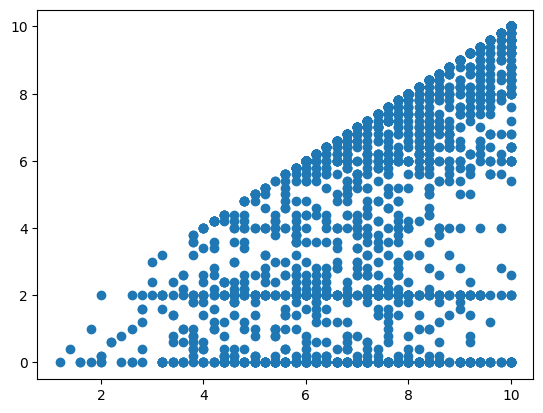

In [55]:
cr = cr.sort_values(by="num_response")
plt.scatter(cr["num_response"], cr["num_correct"])

In [19]:
scoreacs[scoreacs["num_correct"] < scoreacs["num_response"]]

,num_correct,num_response,query rank,subject rank,taxon,responses,accs
question number,,,,,,,
results/indexTerms-class.tsv:49,0.0,4.0,phylum,class,blastocladiomycetes,"blastocladiomycetes belongs to the,chytridiomy...",0.0
results/indexTerms-class.tsv:83,2.0,10.0,phylum,class,jungermanniopsida,"bryophyta,bryophyta,bryophyta,marchantiophyta,...",0.2
results/indexTerms-order.tsv:61,0.0,8.0,phylum,order,amphilepidida,"arthropoda,arthropoda,arthropoda,arthropoda,cr...",0.0
results/indexTerms-order.tsv:62,0.0,6.0,class,order,amphilepidida,"malacostraca,malacostraca,amphilepidida belong...",0.0
results/indexTerms-order.tsv:116,3.0,6.0,class,order,caliciales,"ascomycetes,ascomycetes,leotiomycetes,leotiomy...",0.5
...,...,...,...,...,...,...,...
results/indexTerms-genus.tsv:10984,0.0,10.0,family,genus,eustachys,"poaceae,poaceae,poaceae,poaceae,poaceae,poacea...",0.0
results/indexTerms-genus.tsv:10986,0.0,3.0,phylum,genus,microstegium,"poaceae,poaceae,tracheophyta,poaceae,poaceae,p...",0.0
results/indexTerms-genus.tsv:10989,0.0,10.0,family,genus,microstegium,"poaceae,poaceae,poaceae,poaceae,poaceae,poacea...",0.0


In [22]:
dereference_all(taxonomy.loc[name_to_id("microstegium", "genus")])

id                 microstegium
status                         
rank                           
kingdom                 plantae
phylum                bryophyta
class                 bryopsida
order                funariales
family              funariaceae
genus              microstegium
species                        
name_id                        
scientific_name                
canonical_name                 
Name: 2703555, dtype: object

In [14]:
rank_predictions.head()

,query rank,subject rank,taxon,responses
question number,,,,
results/indexTerms-phylum.tsv:0,kingdom,phylum,annelida,"animalia,animalia,animalia,animalia,animalia,a..."
results/indexTerms-phylum.tsv:1,kingdom,phylum,arthropoda,"animalia,animalia,animalia,animalia,animalia,a..."
results/indexTerms-phylum.tsv:2,kingdom,phylum,brachiopoda,"animalia,animalia,animalia,animalia,animalia,a..."
results/indexTerms-phylum.tsv:3,kingdom,phylum,bryozoa,"animalia,animalia,animalia,animalia,animalia,a..."
results/indexTerms-phylum.tsv:4,kingdom,phylum,chordata,"animalia,animalia,animalia,animalia,animalia,a..."


In [11]:
scoreacs = scores.join(rank_predictions)
scoreacs["accs"] = scores["num_correct"] / scores["num_response"]
scoreacs.groupby("num_response")[["accs"]].mean().T

num_response,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
accs,NaN,0.269542,0.312849,0.299145,0.31039,0.319424,0.378995,0.477009,0.484905,0.450558,0.774371


In [12]:
scoreacs.groupby(["query rank", "num_response"])["accs"].mean().unstack(level=1).T

query rank,class,family,kingdom,order,phylum
num_response,,,,,
0.0,NaN,NaN,NaN,NaN,NaN
1.0,0.406250,0.130435,0.000000,0.204380,0.477273
2.0,0.417582,0.084270,1.000000,0.263780,0.625000
3.0,0.378378,0.200647,0.333333,0.217054,0.579365
4.0,0.440104,0.180412,0.531250,0.212810,0.472222
5.0,0.355769,0.234532,0.333333,0.300000,0.488136
6.0,0.451923,0.228972,0.694444,0.417929,0.348485
7.0,0.582707,0.354227,0.750000,0.467033,0.448463
8.0,0.580078,0.447704,0.701923,0.472917,0.357500


Text(0, 0.5, 'Accuracy')

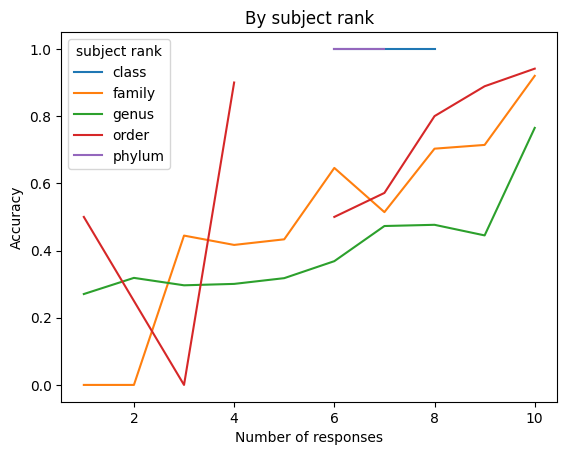

In [104]:
scoreacs.groupby(["subject rank", "num_response"])["accs"].mean().unstack(level=1).T.plot()
plt.title("By subject rank")
plt.xlabel("Number of responses")
plt.ylabel("Accuracy")

In [110]:
scoreacs.groupby(["query rank", "num_response"])["accs"].count().loc["kingdom"]

num_response
0.00        0
1.00        2
2.00        3
3.00        5
4.00        8
5.00        9
6.00       18
7.00       12
8.00       26
9.00       30
10.00    2225
Name: accs, dtype: int64

Text(0, 0.5, 'Accuracy')

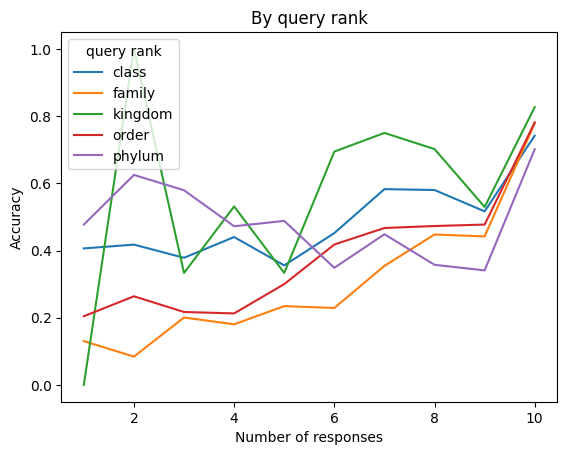

In [103]:
scoreacs.groupby(["query rank", "num_response"])["accs"].mean().unstack(level=1).T.plot()
plt.title("By query rank")
plt.xlabel("Number of responses")
plt.ylabel("Accuracy")

In [13]:
scoreacs.groupby("query rank")[["num_response", "num_correct", "accs"]].mean().T

query rank,class,family,kingdom,order,phylum
num_response,6.419313,7.127331,9.811745,6.245909,7.279040
num_correct,4.232955,4.581075,8.059804,4.003575,4.614920
accs,0.604436,0.541641,0.815806,0.535748,0.616627


In [14]:
scoreacs

,num_correct,num_response,query rank,subject rank,taxon,responses,accs
question number,,,,,,,
results/indexTerms-phylum.tsv:0,10.0,10.0,kingdom,phylum,annelida,"animalia,animalia,animalia,animalia,animalia,a...",1.0
results/indexTerms-phylum.tsv:1,10.0,10.0,kingdom,phylum,arthropoda,"animalia,animalia,animalia,animalia,animalia,a...",1.0
results/indexTerms-phylum.tsv:2,10.0,10.0,kingdom,phylum,brachiopoda,"animalia,animalia,animalia,animalia,animalia,a...",1.0
results/indexTerms-phylum.tsv:3,10.0,10.0,kingdom,phylum,bryozoa,"animalia,animalia,animalia,animalia,animalia,a...",1.0
results/indexTerms-phylum.tsv:4,10.0,10.0,kingdom,phylum,chordata,"animalia,animalia,animalia,animalia,animalia,a...",1.0
...,...,...,...,...,...,...,...
results/indexTerms-genus.tsv:10990,10.0,10.0,kingdom,genus,trichloris,"plantae,plantae,plantae,plantae,plantae,planta...",1.0
results/indexTerms-genus.tsv:10991,0.0,6.0,phylum,genus,trichloris,"trichloris belongs to the taxonomic ph,chlorop...",0.0
results/indexTerms-genus.tsv:10992,0.0,3.0,class,genus,trichloris,"magnoliopsida,poaceae,magnoliopsida,trichloris...",0.0


In [95]:
ranks = [
    "kingdom",
    "phylum",
    "class",
    "order",
    "family",
    "genus"
]

pd.options.display.float_format = '{:,.1%}'.format

acc_matrix = scoreacs.groupby(["subject rank", "query rank"])[["num_response", "num_correct", "accs"]].mean()["accs"].unstack(level=1)
acc_matrix = acc_matrix[ranks[-2::-1]].loc[ranks[:0:-1]]
acc_matrix.T

subject rank,genus,family,order,class,phylum
query rank,,,,,
family,54.2%,NaN,NaN,NaN,NaN
order,53.2%,68.6%,NaN,NaN,NaN
class,59.9%,70.1%,71.2%,NaN,NaN
phylum,59.7%,81.3%,92.2%,93.3%,NaN
kingdom,80.3%,100.0%,95.0%,100.0%,100.0%


In [108]:
pd.options.display.float_format = '{:,.2f}'.format

In [16]:
taxonomy[taxonomy["rank"] == "kingdom"]

,id,status,rank,kingdom,phylum,class,order,family,genus,species,name_id,scientific_name,canonical_name
id,,,,,,,,,,,,,
2,2,accepted,kingdom,2,\n,\n,\n,\n,\n,\n,97064091,archaea,archaea
7,7,accepted,kingdom,7,\n,\n,\n,\n,\n,\n,97526282,protozoa,protozoa
0,0,doubtful,kingdom,0,\n,\n,\n,\n,\n,\n,97528424,incertae sedis,incertae sedis
8,8,accepted,kingdom,8,\n,\n,\n,\n,\n,\n,97528322,viruses,viruses
5,5,accepted,kingdom,5,\n,\n,\n,\n,\n,\n,97080802,fungi,fungi
3,3,accepted,kingdom,3,\n,\n,\n,\n,\n,\n,97064093,bacteria,bacteria
6,6,accepted,kingdom,6,\n,\n,\n,\n,\n,\n,97394585,plantae,plantae
1,1,accepted,kingdom,1,\n,\n,\n,\n,\n,\n,96916018,animalia,animalia
4,4,accepted,kingdom,4,\n,\n,\n,\n,\n,\n,97072620,chromista,chromista


In [43]:
name_to_id("orcuttia", "genus")

'2702919'

In [45]:
taxonomy.loc['6']

id                        6
status             accepted
rank                kingdom
kingdom                   6
phylum                   \n
class                    \n
order                    \n
family                   \n
genus                    \n
species                  \n
name_id            97394585
scientific_name     plantae
canonical_name      plantae
Name: 6, dtype: object

In [38]:
rank_predictions.loc["results/indexTerms-genus.tsv:10863"]["responses"]

'poales,poales,poales,poales,poales,poales,poales,poales,pooideae,poales'

In [35]:
scores[(scores["num_correct"] < 9) * (scores["num_response"] == 9)].join(rank_predictions)

,num_correct,num_response,query rank,subject rank,taxon,responses
question number,,,,,,
results/indexTerms-order.tsv:148,8.0,9.0,phylum,order,harpellales,"zygomycota,zygomycota,zygomycota,zygomycota,zy..."
results/indexTerms-family.tsv:137,0.0,9.0,phylum,family,physodermataceae,"as an ai language model i could not find,chord..."
results/indexTerms-family.tsv:162,0.0,9.0,class,family,glomeraceae,"agaricomycetes,agaricomycetes,agaricomycetes,g..."
results/indexTerms-genus.tsv:44,7.0,9.0,family,genus,pseudonereis,"nereididae,nereididae,phyllodocidae,phyllodoci..."
results/indexTerms-genus.tsv:56,0.0,9.0,phylum,genus,simplisetia,"chordata,as an ai language model i couldnt fin..."
...,...,...,...,...,...,...
results/indexTerms-genus.tsv:10863,0.0,9.0,order,genus,ctenium,"poales,poales,poales,poales,poales,poales,poal..."
results/indexTerms-genus.tsv:10864,0.0,9.0,family,genus,ctenium,"apiaceae,asteraceae,asteraceae,asteraceae,aste..."
results/indexTerms-genus.tsv:10868,0.0,9.0,order,genus,gastridium,"poales,poales,poales,poales,pooideae,poales,po..."


In [ ]:
taxonomy["rank"].value_counts(ascending=True)

rank
kingdom             9
phylum            341
class             819
order            2943
family          33878
form            71757
variety        375349
subspecies     384689
genus          544438
unranked      1193713
species       5043918
Name: count, dtype: int64

In [371]:
# import pickle
# import os

# path = f"processed/tax_maps_{year}.pickle"

# if os.path.exists(path):
#     tax_maps = pickle.load(open(path, "rb"))
# else: # WARNING - this takes about an hour to run
#     scope = set(rank_predictions["taxon"])
#     tax_maps = {}
#     empty = {rank: set() for rank in ranks}

#     for i, row in taxonomy.iterrows():
#         for i, subject_rank in enumerate(ranks):
#             subject = row[subject_rank]
#             if subject in scope:
#                 key = (subject_rank, subject)
#                 old = tax_maps[key] if key in tax_maps else empty
#                 new = {rank: {row[rank]} for rank in ranks[:i]}
#                 tax_maps[key] = pd.Series(old).combine(pd.Series(new), lambda a,b: a | b, set())

#     pickle.dump(tax_maps, open(path, "wb"))

# def get_backbone_classification(taxon, taxon_rank, higher_rank):
#     return taxonomy[taxonomy[taxon_rank] == taxon][higher_rank].drop_duplicates().to_list()

# get_backbone_classification("acer saccharum", "species", "order")